In [1]:
import sys
sys.path.insert(0, '../../')  
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.stats import norm
from gasp import process_data_for_gasp, create_data_mask, train_gasp, run_gasp, simulate_ssfp, simulate_ssfp_sampling, SSFPParams, responses, simulation, sampling

128


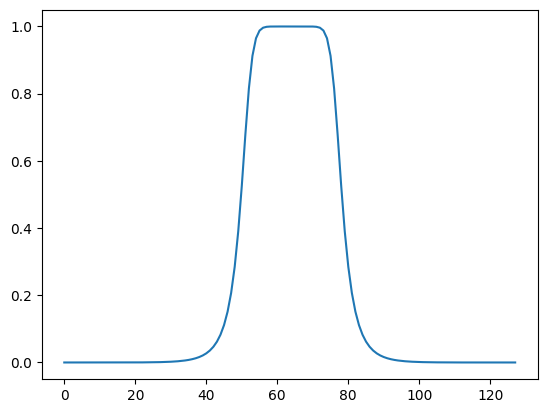

In [2]:
# Parameters
fs = 256  # Sampling frequency (Hz)
t = np.linspace(0, 1, fs, endpoint=False)  # 1 second of data
N = len(t)
bw = 0.1
lowcut = 64 - bw * fs/2  # Lower cutoff frequency (Hz)
highcut = 64 + bw * fs/2 # Upper cutoff frequency (Hz)

nyq = 0.5 * fs
low = lowcut / nyq
high = highcut / nyq

order=5
b, a = signal.butter(order, [low, high], btype='band')
#b, a = signal.cheby1(order, 1, [low, high], btype='band')
#b, a = signal.ellip(order, 1, 40, [low, high], btype='band')

w, h = signal.freqz(b, a, worN=128)
print(len(h))
plt.plot(0.5 * fs * w / np.pi, np.abs(h))
plt.show()

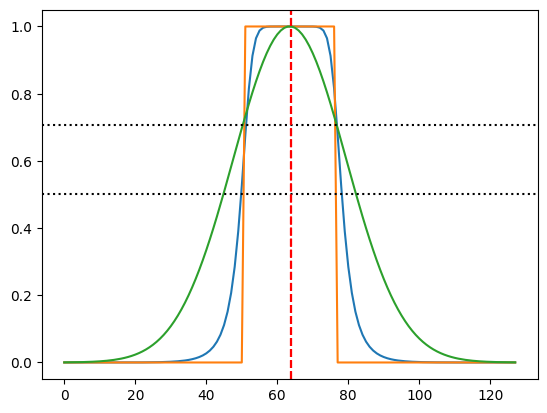

In [3]:
width = 128
D = responses.basspass_filter(128, 0.1, 0)
plt.plot(D) 
D2 = responses.square(128, 0.2, 0)
plt.plot(D2) 
D3 = responses.gaussian(128, 0.5, 0)
plt.plot(D3) 

_3db = 10 ** (-3/20)
plt.axhline(_3db, color='k', linestyle=':', label='-3 dB Line')
plt.axhline(0.5, color='k', linestyle=':', label='-3 dB Line')
plt.axvline(64, color='r', linestyle='--', label='Design Lowcut')
plt.axvline(64, color='r', linestyle='--', label='Design Lowcut')
plt.axvline(64, color='r', linestyle='--', label='Design Lowcut')

plt.show()

In [11]:
def plot_RMSE(D, sampling_schemes, alpha=np.deg2rad(60), width = 128):
    n_points = np.linspace(6, 48, 48-6, endpoint=False).astype(np.int64) 
    RMSE = np.zeros((len(sampling_schemes), len(n_points)))
    print(RMSE.shape)
    for i, scheme in enumerate(sampling_schemes):
        print(f"scheme={scheme[0]}")
        for j, n in enumerate(n_points):
            #print(f"n={n}")
            TRs, PCs = scheme[1](n)
            params = SSFPParams(n, alpha, TRs, PCs)
            M = simulate_ssfp_sampling(width=width, height=1, params=params, minTR = np.min(params.TRs), gradient = 2 * np.pi, phantom_type='line')
            Ic, An = train_gasp(M, D)
            RMSE[i, j] = np.sqrt(np.mean((np.abs(Ic) - D)**2))
            #plt.plot(np.abs(Ic).T)

    plt.plot(n_points, RMSE.T)

(1, 42)
scheme=grid_TR
(1, 42)
scheme=grid_TR
(1, 42)
scheme=grid_TR


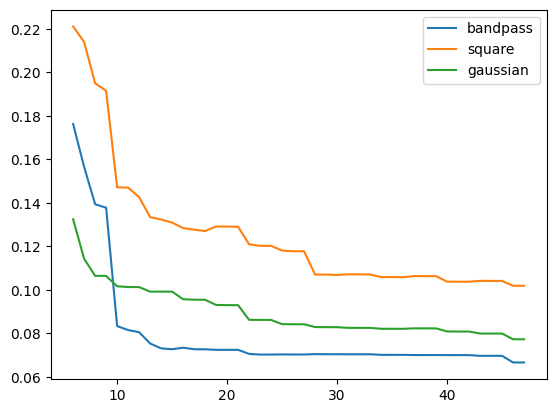

In [13]:
tr_range = (5e-3, 20e-3)

sampling_schemes = [
    ('grid_TR', lambda n: sampling.grid_TR_sampling(n_points=n, TRs=[5e-3, 10e-3, 20e-3])),
]

plot_RMSE(D, sampling_schemes, alpha=np.deg2rad(60))
plot_RMSE(D2, sampling_schemes, alpha=np.deg2rad(60))
plot_RMSE(D3, sampling_schemes, alpha=np.deg2rad(60))
plt.legend(['bandpass','square','gaussian'])
plt.show()